In [1]:
# Importing packages
import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from io import StringIO
from shapely.geometry import Point
import osr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns
import os
import sys
sys.path.insert(0, os.path.abspath(''))

import data_processing_helper as dp
import practical_functions as pf
import xarray as xr
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import requests as rq
from shapely.wkt import loads
import geoplot as gplt

plt.style.use('ggplot') # use ggplot style

/home/lavinia/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Loading the Shapefiles for the Pacific

In [2]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp')
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp')
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp')

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

## Loading the Survey folder
It contains the coordinates of the Survey and the percentage of algae, corals, soft_corals or other_invertebrates


In [3]:
Survey_global = pd.read_csv("../Data/Reefs/seaviewsurvey_surveys.csv")
Survey_global.head()

surveyid  transectid  surveydate ocean country           folder_name  \
0     10001       10001    20120916   PAC     AUS  PAC_AUS_10001_201209   
1     10002       10002    20120917   PAC     AUS  PAC_AUS_10002_201209   
2     10003       10003    20120918   PAC     AUS  PAC_AUS_10003_201209   
3     10004       10004    20120920   PAC     AUS  PAC_AUS_10004_201209   
4     10005       10005    20120920   PAC     AUS  PAC_AUS_10005_201209   

   lat_start   lng_start    lat_end     lng_end  pr_hard_coral  pr_algae  \
0 -16.189023  145.898104 -16.191761  145.894088         0.1856    0.3724   
1 -16.189303  145.898254 -16.175947  145.889736         0.1364    0.4766   
2 -16.175768  145.891676 -16.181218  145.888904         0.2475    0.5653   
3 -16.536645  147.806796 -16.524287  147.843325         0.1242    0.5706   
4 -16.529216  147.802582 -16.521689  147.836180         0.0781    0.7894   

   pr_soft_coral  pr_oth_invert  pr_other  
0         0.2710         0.0010    0.1700  
1         0.3079         0.0020    0.0771  
2         0.0747         0.0207    0.0917  
3         0.0279         0.0023    0.2748  
4         0.0096         0.0029    0.1201

In [132]:
Survey = Survey_global[(Survey_global["country"] == "AUS") | (Survey_global["country"] == "IDN") | (Survey_global["country"] == "TLS")| (Survey_global["country"] == "SLB")]
print("We now have a total of :",Survey.shape[0], " Surveys")
Survey.head()

We now have a total of : 421  Surveys


surveyid  transectid  surveydate ocean country           folder_name  \
0     10001       10001    20120916   PAC     AUS  PAC_AUS_10001_201209   
1     10002       10002    20120917   PAC     AUS  PAC_AUS_10002_201209   
2     10003       10003    20120918   PAC     AUS  PAC_AUS_10003_201209   
3     10004       10004    20120920   PAC     AUS  PAC_AUS_10004_201209   
4     10005       10005    20120920   PAC     AUS  PAC_AUS_10005_201209   

   lat_start   lng_start    lat_end     lng_end  pr_hard_coral  pr_algae  \
0 -16.189023  145.898104 -16.191761  145.894088         0.1856    0.3724   
1 -16.189303  145.898254 -16.175947  145.889736         0.1364    0.4766   
2 -16.175768  145.891676 -16.181218  145.888904         0.2475    0.5653   
3 -16.536645  147.806796 -16.524287  147.843325         0.1242    0.5706   
4 -16.529216  147.802582 -16.521689  147.836180         0.0781    0.7894   

   pr_soft_coral  pr_oth_invert  pr_other  
0         0.2710         0.0010    0.1700  
1         0.3079         0.0020    0.0771  
2         0.0747         0.0207    0.0917  
3         0.0279         0.0023    0.2748  
4         0.0096         0.0029    0.1201

In [5]:
# Change date format 
Survey['surveydate'] = pd.to_datetime(Survey['surveydate'], format='%Y%m%d')

In [6]:
# Make pacific survey into GeoDataFrame
gSurvey = gpd.GeoDataFrame(Survey, geometry = gpd.points_from_xy(Survey.lng_start, Survey.lat_start))
gSurvey["country"].value_counts()

AUS    261
IDN    114
TLS     26
SLB     20
Name: country, dtype: int64

We can see that most surveys were taken in Australia followed by Indonesia. With a total of 421 surveys

In [7]:
# Keep only month and year
gSurvey['surveydate'] = gSurvey['surveydate'].dt.strftime('%Y-%m')

## Loading the shape files

In [8]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')

drop_cols_shape = ['left', 'top', 'right', 'bottom', 'AREA']

gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp').drop(columns = drop_cols_shape)
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp').drop(columns = drop_cols_shape)
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp').drop(columns = drop_cols_shape)

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

#### Degree Heating Week
The DHW shows how much heat stress has accumulated in an area over the past 12 weeks (3 months)

In [9]:
DHW_GBR = pd.read_csv("../Data/Environmental_data/DHW_GBR.csv")
DHW_IDN = pd.read_csv("../Data/Environmental_data/DHW_Indonesia.csv")
DHW_SLB = pd.read_csv("../Data/Environmental_data/DHW_Solomon.csv")
DHW_TLS = pd.read_csv("../Data/Environmental_data/DHW_Timor.csv")
DHW_GBR.name = "GBR"
DHW_IDN.name = "IDN"
DHW_SLB.name = "SLB"
DHW_TLS.name = "TLS"

In [10]:
# Reorganise data frames
def fix_DHW(df, shapefile):
    if (not isinstance(df["id"][0], np.int64)):
        df["id"] = df["id"].str.replace('R', "").astype(int)
    if (not isinstance(shapefile["id"][0], np.int64)):
        shapefile["id"] = shapefile["id"].str.replace('R', "").astype(int)

    df_temp = df.drop(columns = "id")
    
    df_temp.columns = pd.to_datetime(df_temp.columns)
    df_temp.insert(0, "id", df["id"])
    df = df_temp.copy()
    if("geometry" not in df.columns):
        df = df.merge(shapefile, on = "id")
    return df


In [11]:



DHW_GBR = fix_DHW(DHW_GBR, gdf_AUS)
DHW_IDN = fix_DHW(DHW_IDN, gdf_IND)
DHW_SLB = fix_DHW(DHW_SLB, gdf_SLB)
DHW_TLS = fix_DHW(DHW_TLS, gdf_TLS)
DHW_GBR.name = "GBR"
DHW_IDN.name = "IDN"
DHW_SLB.name = "SLB"
DHW_TLS.name = "TLS"

In [12]:
def plot_DHW_years(df, df1, df2, df3):
    
    fig = df.drop(columns = "id").mean(axis = 0).plot(figsize = (20,7), label = f"DHW_{df.name}")
    df1.drop(columns = "id").mean(axis = 0).plot(label = f"DHW_{df1.name}")
    df2.drop(columns = "id").mean(axis = 0).plot(label = f"DHW_{df2.name}")
    df3.drop(columns = "id").mean(axis = 0).plot(label = f"DHW_{df3.name}")
    plt.title("DHW throughout years")
    plt.ylabel("DHW value")
    plt.xlabel("Date")
    plt.hlines(4, 0,df.shape[0], color = "yellow", label ="Warning")
    plt.legend()
    

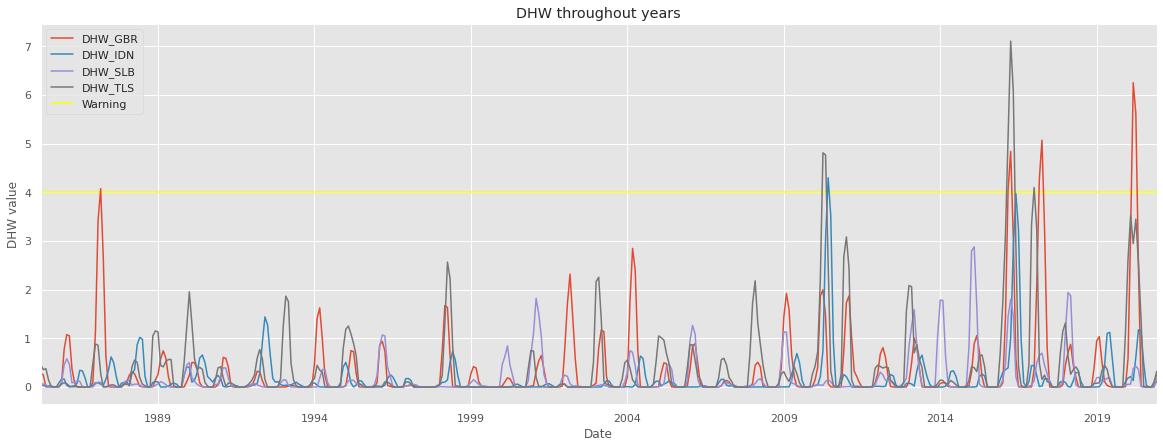

In [13]:
plot_DHW_years(DHW_GBR,DHW_IDN,DHW_SLB,DHW_TLS)

In [14]:
def plot_mean_10_years(df, df1, df2, df3):
    fig = df[df.columns[298:]].mean(axis = 0).plot(figsize = (20,7), label = f"DHW_{df.name}")
    df1[df1.columns[298:]].mean(axis = 0).plot(label = f"DHW_{df1.name}")
    df2[df2.columns[298:]].mean(axis = 0).plot(label = f"DHW_{df2.name}")
    df3[df3.columns[298:]].mean(axis = 0).plot(label = f"DHW_{df3.name}")
    plt.title("DHW throughout 10 years")
    plt.ylabel("DHW value")
    plt.xlabel("Date")
    plt.legend()
    

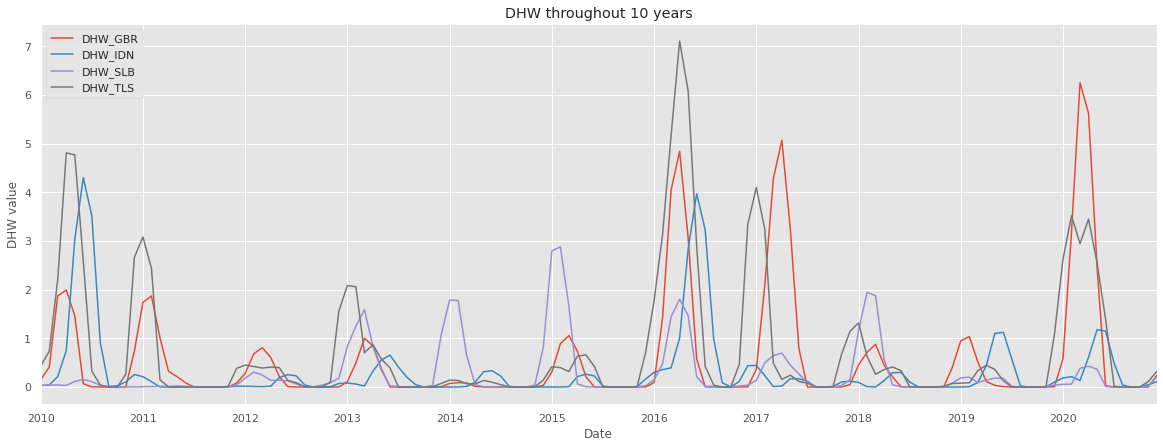

In [15]:
plot_mean_10_years(DHW_GBR,DHW_IDN,DHW_SLB,DHW_TLS)

In [16]:
# add a column with number of times DHW has exceedeed "count" 
def add_warning_DHW(df, count):
    if("Exceed_count" not in df.columns):
    
        df["Exceed_count"] = (df.drop(columns = ["id", "geometry"]).iloc[:] > count).sum(axis = 1)
    

In [17]:
add_warning_DHW(DHW_GBR, 4)
add_warning_DHW(DHW_IDN, 4)
add_warning_DHW(DHW_SLB, 4)
add_warning_DHW(DHW_TLS, 4)

In [18]:
g_DHW_GBR = pf.make_geo_frame(DHW_GBR)
g_DHW_IDN = pf.make_geo_frame(DHW_IDN)
g_DHW_SLB = pf.make_geo_frame(DHW_SLB)
g_DHW_TLS = pf.make_geo_frame(DHW_TLS)

In [19]:
print("DHW_GBR Exceeds 4 DHW, ",DHW_GBR["Exceed_count"].mean().round(), " times")
print("DHW_IDN Exceeds 4 DHW, ",DHW_IDN["Exceed_count"].mean().round(), " times")
print("DHW_SLB Exceeds 4 DHW, ",DHW_SLB["Exceed_count"].mean().round(), " times")
print("DHW_TLS Exceeds 4 DHW, ",DHW_TLS["Exceed_count"].mean().round(), " times")


DHW_GBR Exceeds 4 DHW,  9.0  times
DHW_IDN Exceeds 4 DHW,  3.0  times
DHW_SLB Exceeds 4 DHW,  1.0  times
DHW_TLS Exceeds 4 DHW,  8.0  times


<AxesSubplot:>

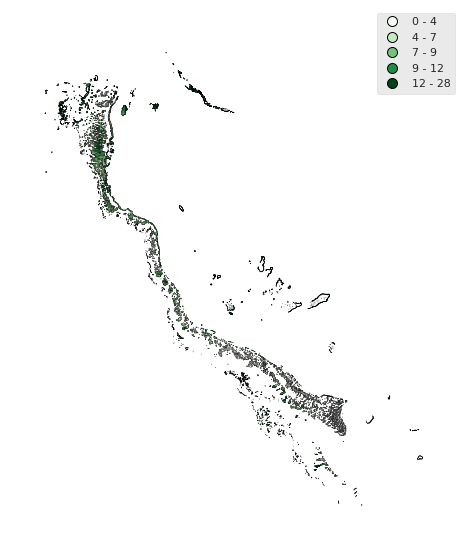

In [20]:
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
import mapclassify as mc
ax = gplt.polyplot(g_DHW_GBR, figsize = (20,10))
scheme = mc.Quantiles(g_DHW_GBR["Exceed_count"], k=5)
gplt.choropleth(
    g_DHW_GBR, hue='Exceed_count', edgecolor="black",
  linewidth=0.1, scheme = scheme, ax = ax,
    cmap='Greens', legend=True
)

### Loading the Surface Sea Temperature 

In [21]:
SST_GBR = pd.read_csv("../Data/Environmental_data/SST_GBR.csv")
SST_IDN = pd.read_csv("../Data/Environmental_data/SST_Indonesia.csv")
SST_SLB = pd.read_csv("../Data/Environmental_data/SST_Solomon.csv")
SST_TLS = pd.read_csv("../Data/Environmental_data/SST_Timor.csv")
SST_GBR.name = "GBR"
SST_IDN.name = "IDN"
SST_SLB.name = "SLB"
SST_TLS.name = "TLS"

In [22]:
SST_GBR = fix_DHW(SST_GBR, gdf_AUS)
SST_IDN = fix_DHW(SST_IDN, gdf_IND)
SST_SLB = fix_DHW(SST_SLB, gdf_SLB)
SST_TLS = fix_DHW(SST_TLS, gdf_TLS)
SST_GBR.name = "GBR"
SST_IDN.name = "IDN"
SST_SLB.name = "SLB"
SST_TLS.name = "TLS"

In [23]:
def plot_SST_years(df, df1, df2, df3):
    
    fig = df.drop(columns = "id").mean(axis = 0).plot(figsize = (10,7), label = f"SST_{df.name}", color = "red")
    df1.drop(columns = "id").mean(axis = 0).plot(label = f"SST_{df1.name}", color = "blue")
    df2.drop(columns = "id").mean(axis = 0).plot(label = f"SST_{df2.name}", color = "purple")
    df3.drop(columns = "id").mean(axis = 0).plot(label = f"SST_{df3.name}", color = "grey")
    plt.hlines(df.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "red", linestyles= 'dashed')
    plt.hlines(df1.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "blue", linestyles= 'dashed')
    plt.hlines(df2.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "purple", linestyles= 'dashed')
    plt.hlines(df3.drop(columns = "id").mean(axis = 0).mean(), 0,df.shape[0], color = "grey", linestyles= 'dashed')
    plt.title("SST_ throughout years")
    plt.ylabel("SST_ value")
    plt.xlabel("Date")
    
    plt.legend()
    

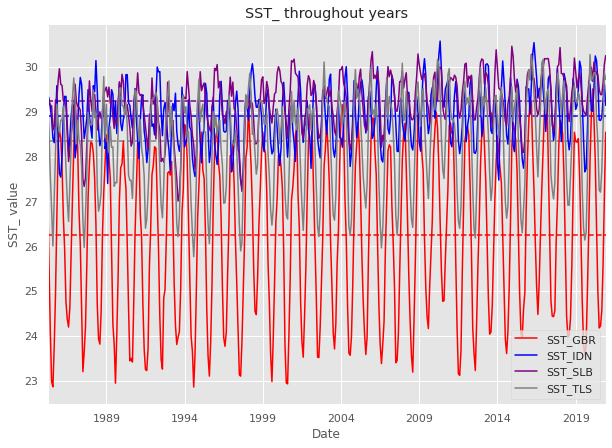

In [24]:
plot_SST_years(SST_GBR,SST_IDN,SST_SLB,SST_TLS)

## Since the rest of the environmental data are real heavy, we will work and analyse the merged dataset

In [305]:
#df_Survey_merged = pd.read_csv("../Data/merged_files_latest.csv")
#df_Survey_merged = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")
df_Survey_merged = pd.read_csv("../Data/merged_files_latest.csv")
df_Survey_merged['surveydate'] = pd.to_datetime(df_Survey_merged['surveydate'], format='%Y-%m')
df_Survey_merged["year"] = df_Survey_merged["surveydate"].dt.year
df_Survey_merged['surveydate'] = df_Survey_merged['surveydate'].dt.strftime('%Y-%m')

In [307]:
# Make geodataframe
df_Survey_merged['geometry'] = df_Survey_merged['geometry'].apply(loads)
df_Survey_merged = pf.make_geo_frame(df_Survey_merged)

In [308]:
dp.swap_coordinates(df_Survey_merged)

lat         lon  transectid surveydate  pr_hard_coral  pr_algae  \
0   -18.833291  147.651632     11002.0    2012-10         0.1586    0.6852   
1   -18.806353  147.669078     11001.0    2012-10         0.1141    0.6164   
2   -18.665839  147.722256     11004.0    2012-10         0.0331    0.8568   
3   -18.656207  147.724072     11003.0    2012-10         0.0485    0.9070   
4   -18.590921  147.565032     11005.0    2012-10         0.4016    0.4756   
..         ...         ...         ...        ...            ...       ...   
411  -8.221244  125.530967     30018.0    2014-07         0.1706    0.6726   
412  -8.211822  125.622274     30014.0    2014-07         0.1706    0.5924   
413  -8.183781  125.638740     30013.0    2014-07         0.1273    0.7098   
414  -8.538504  125.606825     30026.0    2014-08         0.1017    0.5661   
415  -8.518996  125.624035     30025.0    2014-08         0.0820    0.5688   

     pr_soft_coral  pr_oth_invert  pr_other country  ...        par  \
0           0.0978         0.0216    0.0366     AUS  ...  50.354000   
1           0.0497         0.0024    0.2173     AUS  ...  50.343998   
2           0.0230         0.0068    0.0805     AUS  ...  49.325996   
3           0.0225         0.0098    0.0121     AUS  ...  49.325996   
4           0.0185         0.0046    0.0998     AUS  ...  50.809998   
..             ...            ...       ...     ...  ...        ...   
411         0.0805         0.0244    0.0520     TLS  ...  56.494000   
412         0.1170         0.0689    0.0510     TLS  ...  54.964000   
413         0.0633         0.0483    0.0513     TLS  ...  55.288000   
414         0.2066         0.0140    0.1117     TLS  ...  42.652000   
415         0.1600         0.0264    0.1627     TLS  ...  42.652000   

     closest_port  year  distance_urban  dist_marine_protection  Population  \
0      404.245121  2012    80426.081521            70755.568101  22733465.0   
1      416.935248  2012    83697.813591            74241.879981  22733465.0   
2      520.150084  2012    98074.289376            84840.553472  22733465.0   
3      601.594003  2012    98944.854640            84525.168032  22733465.0   
4      533.509550  2012    93212.069927            89323.079270  22733465.0   
..            ...   ...             ...                     ...         ...   
411    174.526710  2014    41512.885878           164827.725038   1174331.0   
412    321.991143  2014    39539.502321           174882.569933   1174331.0   
413    442.709526  2014    41965.667133           176750.240429   1174331.0   
414    386.734287  2014     7100.173207           176625.962265   1174331.0   
415    457.549400  2014     9955.836159           178072.451834   1174331.0   

     Population_growth    agr_type   Broad_type       dist_agr  
0             1.745820  sugar cane  Other crops   74877.709981  
1             1.745820  sugar cane  Other crops   78264.493182  
2             1.745820  sugar cane  Other crops   94839.445880  
3             1.745820  sugar cane  Other crops   95919.730190  
4             1.745820  sugar cane  Other crops   99649.232437  
..                 ...         ...          ...            ...  
411           1.807556     sawlogs       Forest  630278.806423  
412           1.807556     sawlogs       Forest  622374.677769  
413           1.807556     sawlogs       Forest  622554.104406  
414           1.807556     sawlogs       Forest  604910.454910  
415           1.807556     sawlogs       Forest  604356.985227  

[416 rows x 29 columns]

### SST


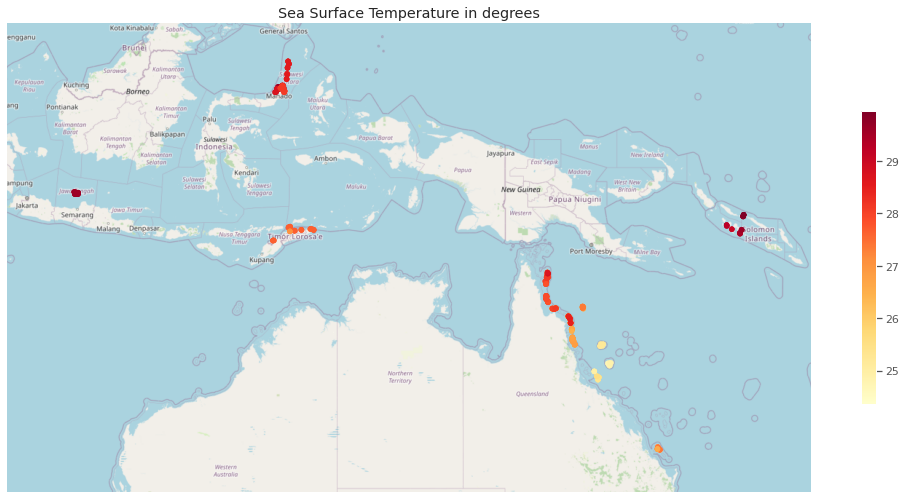

In [42]:

ax = gplt.webmap(df_Survey_merged, figsize = (18,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd",
    hue='SST', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Sea Surface Temperature in degrees");

### Degree Heating Week 

Text(0.5, 1.0, 'Degree Heating Week')

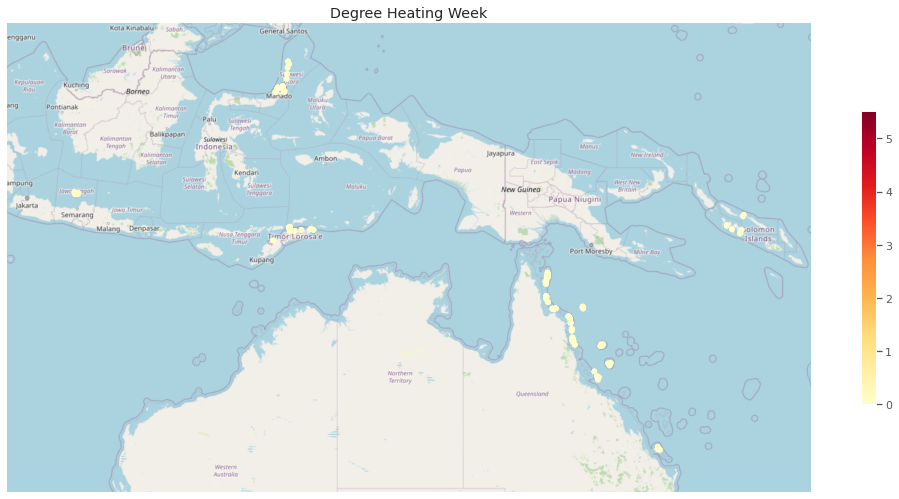

In [43]:

ax = gplt.webmap(df_Survey_merged, figsize = (18,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd", 
    hue='DHW', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Degree Heating Week")

### Wind 

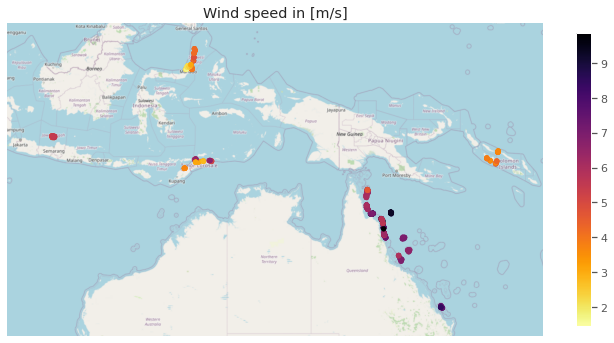

In [44]:

ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "inferno_r",
    hue='wind_speed',
    ax=ax, legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Wind speed in [m/s]");

### Chlorophyll
To heavy to work with on the big scale, I thus analyse only the merged dataframe

Text(0.5, 1.0, 'Chlorophyll in [mg/m³]')

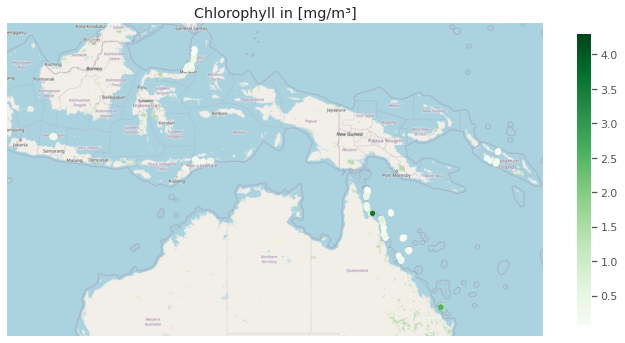

In [45]:
import matplotlib.colors as colors
ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "Greens",
    hue='Chlor', 
    ax=ax, legend = True, legend_kwargs={'shrink': 0.45} 
);
plt.title("Chlorophyll in [mg/m³]")

### Elevation

Text(0.5, 1.0, 'Elevation in meters with sea level reference')

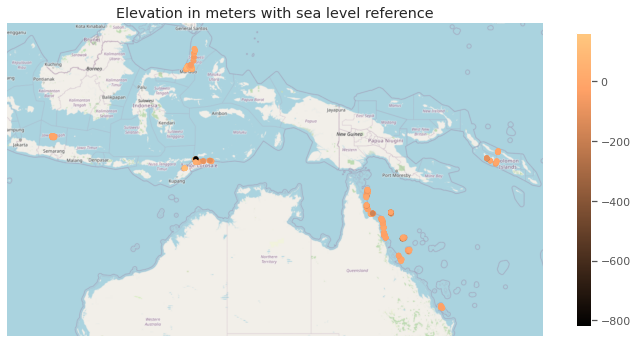

In [46]:
ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "copper",
    hue='elevation',
    ax=ax, legend = True, legend_kwargs={'shrink': 0.45} 
);
plt.title("Elevation in meters with sea level reference")

### Solar radiation

Text(0.5, 1.0, 'Solar radiation in [J m**-2]')

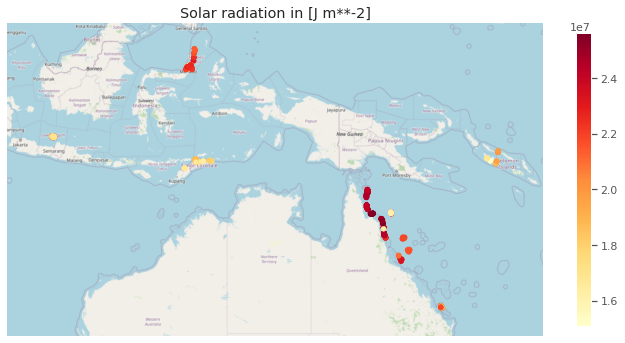

In [47]:

ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd", 
    hue='solar_rad', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Solar radiation in [J m**-2]")

### Solar radiation in Clear Sky

Text(0.5, 1.0, 'Solar radiation in clear sky [J m**-2]')

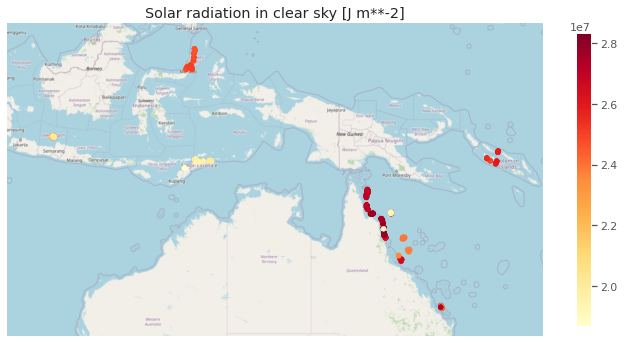

In [48]:

ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "YlOrRd", 
    hue='solar_rad_clear_sky', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Solar radiation in clear sky [J m**-2]")

### Closest port

Text(0.5, 1.0, 'Distance to closest port in [meters]')

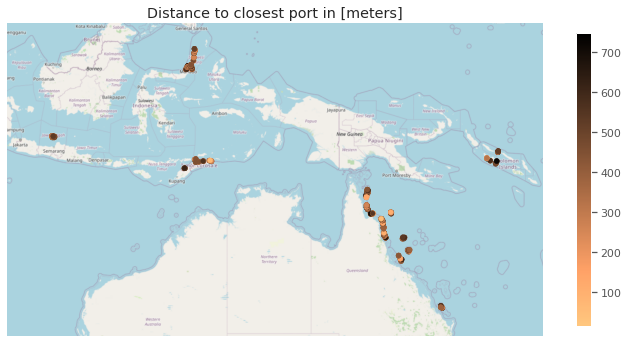

In [49]:


ax = gplt.webmap(df_Survey_merged, figsize = (12,12))
gplt.pointplot(
    df_Survey_merged, cmap = "copper_r", 
    hue='closest_port', 
    ax=ax,legend = True, legend_kwargs={'shrink': 0.45}
);
plt.title("Distance to closest port in [meters]")

In [379]:
df["surveydate"].value_counts()

2014-10    48
2012-10    40
2016-10    37
2017-10    35
2012-12    33
2014-11    32
2018-06    28
2014-09    27
2014-07    24
2012-09    23
2012-11    22
2014-12    14
2014-05    13
2018-05    13
2016-11    12
2016-03    11
2014-02     2
2014-08     2
Name: surveydate, dtype: int64

### Updated data viz version

In [309]:
df_IND_diff = pd.read_csv("../Data/Intermediate_csv/diff_IND.csv")
df_AUS_diff = pd.read_csv("../Data/Intermediate_csv/diff_AUS.csv")

In [310]:
from shapely.wkt import loads
from shapely import wkt
df_IND_diff['geometry'] = df_IND_diff['geometry'].apply(wkt.loads)
df_AUS_diff['geometry'] = df_AUS_diff['geometry'].apply(wkt.loads)
#geo_loads(df_IND_diff)
df_IND_diff = pf.make_geo_frame(df_IND_diff)
df_AUS_diff = pf.make_geo_frame(df_AUS_diff)

In [311]:
df_AUS_diff.drop(columns =['pr_hard_coral', 'pr_soft_coral', 'pr_algae', 'pr_oth_invert',
       'pr_other', 'others'], inplace = True)
df_IND_diff.drop(columns =['transectid', 'pr_hard_coral', 'pr_soft_coral', 'pr_algae',
       'pr_oth_invert', 'pr_other',  'others'], inplace = True)

In [312]:
df_diff = pd.concat([df_IND_diff, df_AUS_diff])

In [313]:
df_Survey_merged_diff = pd.merge(df_Survey_merged,df_diff, on = ["geometry", "year"], how = "outer")
df = df_Survey_merged_diff.copy()

### Distribution plots for numerical values depending on country

Text(0.5, 0.98, 'Distribution of all features by Country')

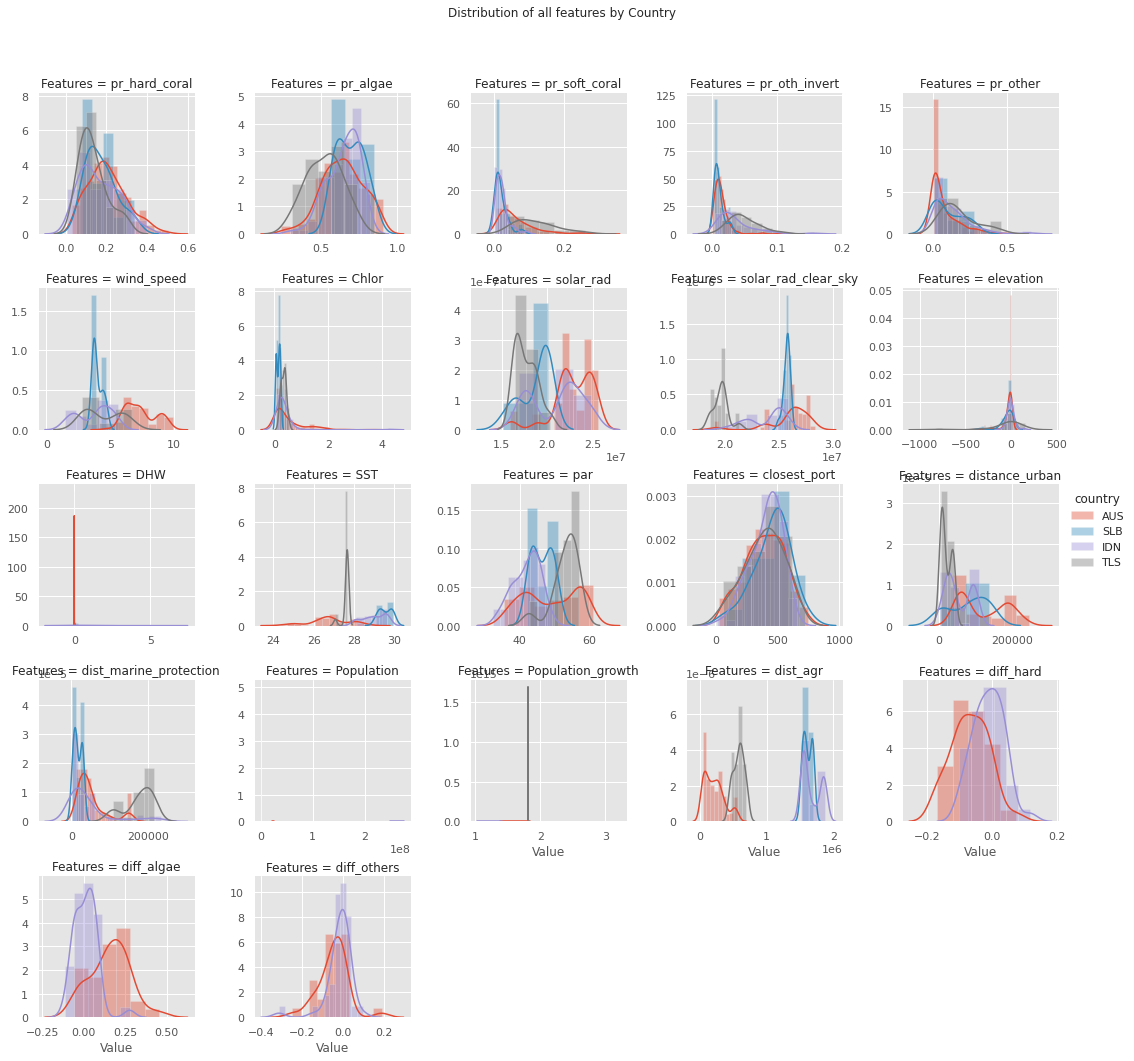

In [381]:
numeric_features= df.drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_country =  pd.DataFrame(df_Survey_merged_diff["country"])
merged_num = pd.merge(df_country, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "country",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features by Country")

**Interpretation**

Main take-aways: 
- Hard corals have a mean of below 20 % for all countries
- Algea has a broad distribution. highest values for Indonesia, lowest for Timor-Leste
- Wind speed is highest for Australia 
- No specific note for Chlorophyll
- Solar radiation is highest in Australia
- Elevation is similar to all ...
- Australia has lowest SST (link with wind_speed?) but spread out, due to shape or years ? Solomon highest 
- PAR has season variability (paper [https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-0851-3_451]), but highest in TLS (careful with Survey month)
- Closest ports are whithin the same distance for all survey points. Outliers might tell us more of a possible link
- Timor Leste, has the closest Urban places and Australia is quite spread out. This might be interesting because we saw a gradient of hard coral difference between the North and the South during first target variable presentation
- Australia, Solomon and Indesia are close to marine protected areas whereas Timor Leste isn't. Looking at the hard coral distribution, we note that it tends to hold the lowest proportion
- Pity for agriculture that we only have data for Australia which explains the distance 
- We see a positive difference (a.k.a increase) for hard corals in Indonesia, whereas we see a decrease for Australia. The opposite trend can be observed for algae

Text(0.5, 1.0, 'Population')

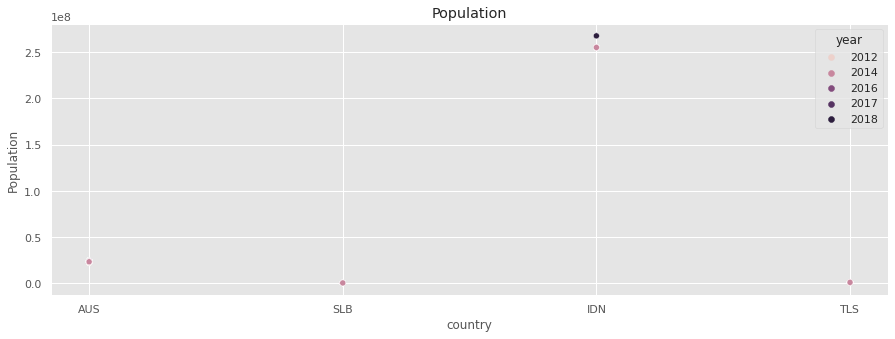

In [431]:
plt.figure(figsize = (15, 5))
sns.scatterplot(data = df_Survey_merged_diff ,y = "Population", x = "country", hue = "year")

plt.title("Population")


**Interpretation**

Main take-aways: 
- The population is greatets by far in Indonesia, its population has inctreased

Text(0.5, 1.0, 'Population Growth')

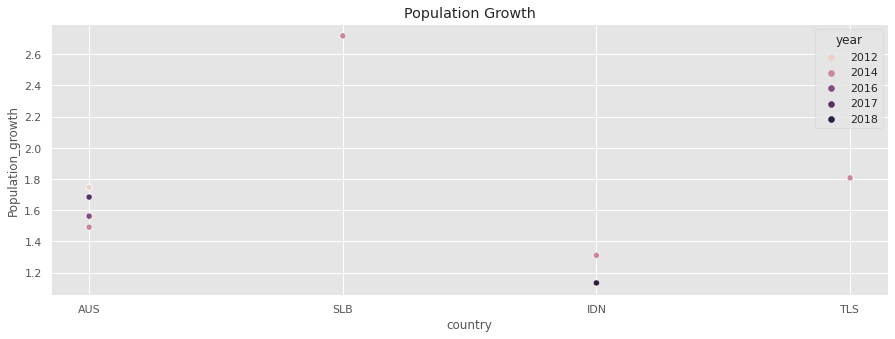

In [435]:
plt.figure(figsize = (15, 5))
sns.scatterplot(data = df_Survey_merged_diff ,y = "Population_growth", x = "country", hue = "year")
plt.title("Population Growth")

**Interpretation**

Main take-aways:

- Population growth is decreasing for the Indonesia and Australia. We don't have the values for TLS and SLB. but their growth is higher.

### Distribution plots for numerical values depending on year

In [437]:
df.columns

Index(['lat', 'lon', 'transectid', 'surveydate', 'pr_hard_coral', 'pr_algae',
       'pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country', 'geometry',
       'wind_speed', 'Chlor', 'solar_rad', 'solar_rad_clear_sky', 'elevation',
       'id', 'DHW', 'SST', 'par', 'closest_port', 'year', 'distance_urban',
       'dist_marine_protection', 'Population', 'Population_growth', 'agr_type',
       'Broad_type', 'dist_agr', 'diff_hard', 'diff_algae', 'diff_others'],
      dtype='object')

Text(0.5, 0.98, 'Distribution of all features by Year')

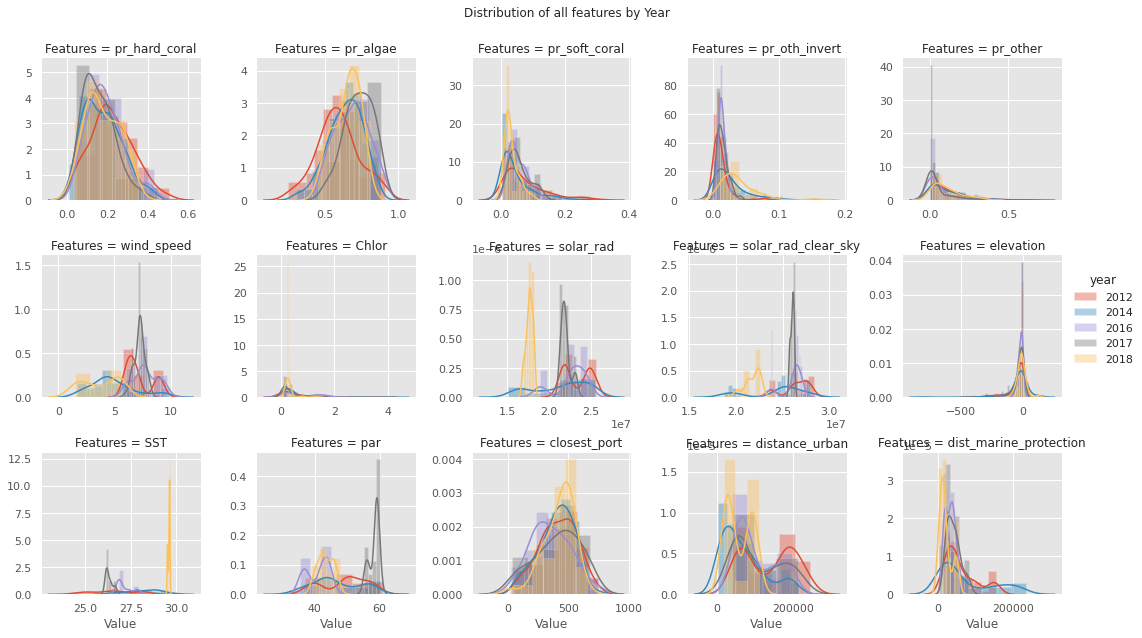

In [441]:
numeric_features= df.drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type','dist_agr', 'diff_hard', 'diff_algae', 'DHW','diff_others', 'Population_growth','Population'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_Survey_merged_diff["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features by Year")

**Interpretation**

Main take-aways: 

- I would not make any intersting assumptions since some countries only have values for one year,  they are the only represented. It would be better for the years to look at countries such as Australia and Indonesia 


### Australia

Text(0.5, 0.98, 'Distribution of all features for Australia by Year')

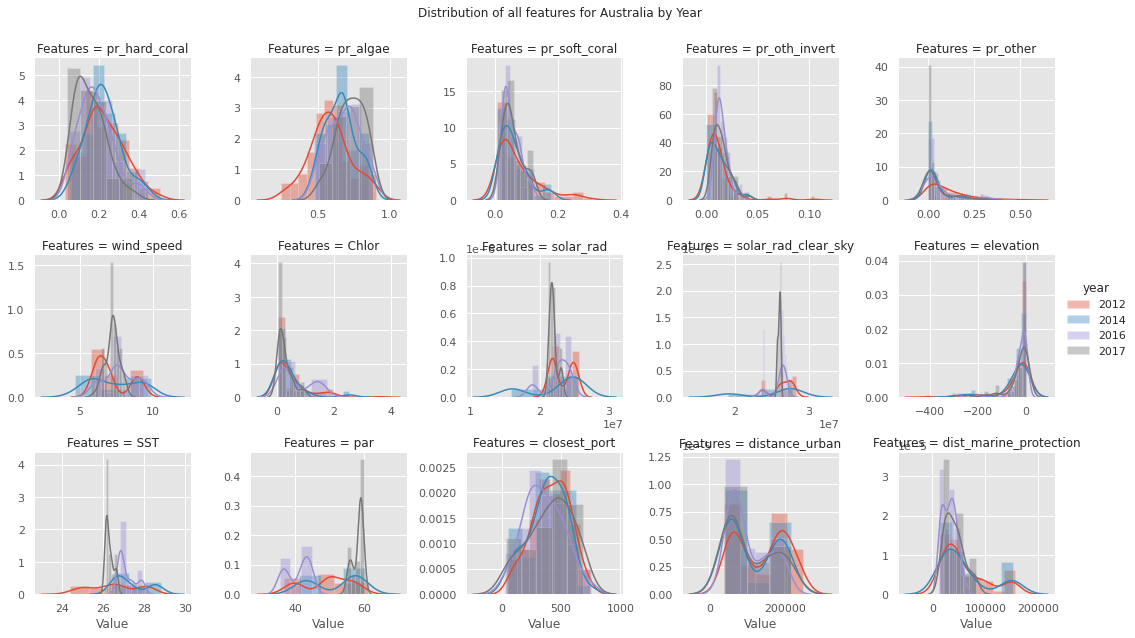

In [443]:
numeric_features= df[df["country"] == "AUS"].drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type','dist_agr', 'diff_hard', 'diff_algae', 'DHW','diff_others', 'Population_growth','Population'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_Survey_merged_diff[df_Survey_merged_diff["country"] == "AUS"]["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features for Australia by Year")

**Interpretation**

Main take-aways: 

- Hard Corals degraded with time, opposite for algae
- Wind speed has mostly the same distribution
- PAR seems to have increased with time 
- SST and other variable are constant


### Indonesia

Text(0.5, 0.98, 'Distribution of all features for Indonesia by Year')

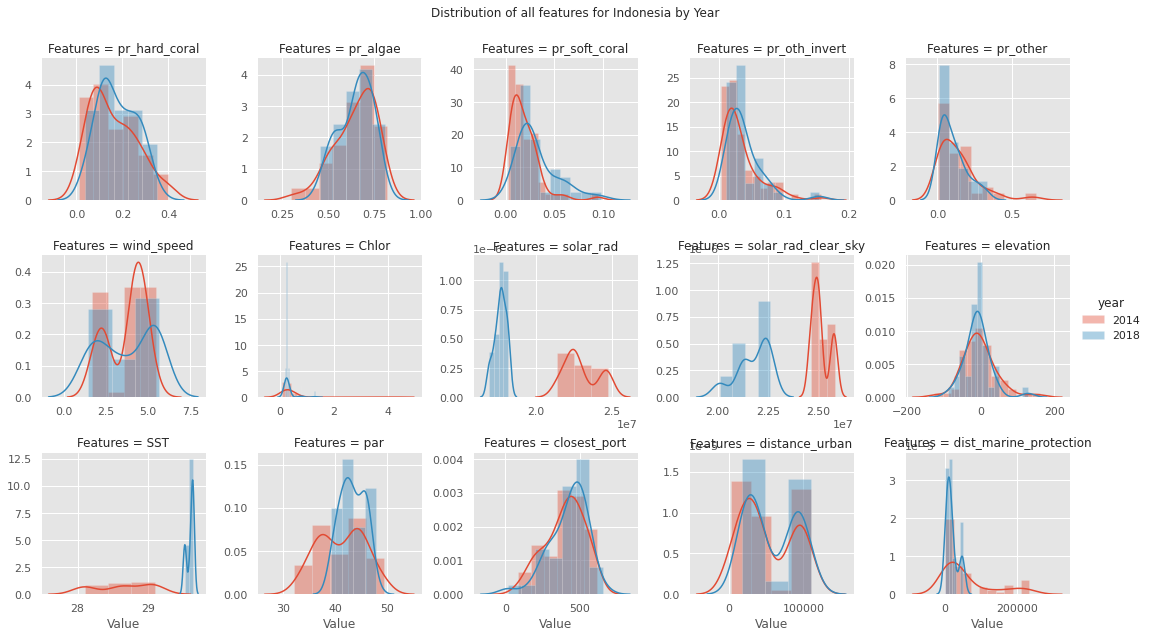

In [444]:
numeric_features= df[df["country"] == "IDN"].drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year', 'agr_type', 'Broad_type','dist_agr', 'diff_hard', 'diff_algae', 'DHW','diff_others', 'Population_growth','Population'])
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
df_year=  pd.DataFrame(df_Survey_merged_diff[df_Survey_merged_diff["country"] == "IDN"]["year"])
merged_num = pd.merge(df_year, numeric_features, left_index=True, right_on='level_0')
g = sns.FacetGrid(data =merged_num, col="Features",  hue = "year",col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "Value")
g.add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle("Distribution of all features for Indonesia by Year")

**Interpretation**

Main take-aways:

- Hard Corals slight increase with time, slight decrease in algae
- Difference in solar radiation but careful (in 2014: october and september survey, in 2018: may and june). So higher in their summer. makes sense ....
- temperature is higher in 2018 even though it is not the summer.


### Correlation Matrix

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

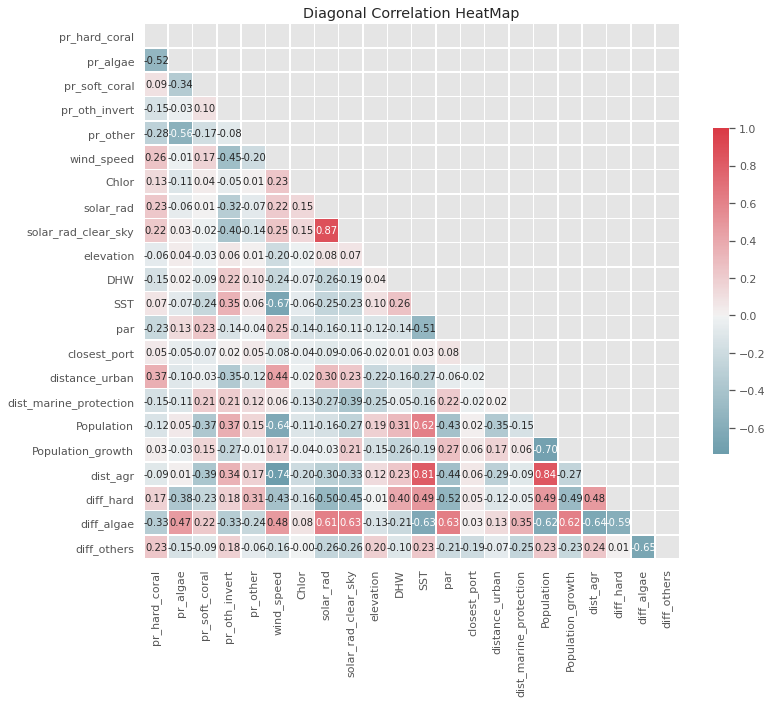

In [376]:
f, ax = plt.subplots(figsize=(12, 12))
corr = df.drop(columns = ['lat', 'lon', 'transectid', 'surveydate', 'country', 'geometry','id', 'year']).corr()
 
# TO display diagonal matrix instead of full matrix.
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Generate a custom diverging colormap.
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio.
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# plt.subplots_adjust(top=0.99)
plt.title("Diagonal Correlation HeatMap")

**Interpretation**

Main take-aways:

- Opposite interaction between algae and hard corals
- hard corals and urban distance, small correlation. Larger distance, larger hard coral.
- More wind, less SST (- 0.66)
- More wind with greater distance to urban place (0.44)
- More SST, less PAR (-0.51) ?? 
- More SST, more population...
- Greater distance to agriculture, greater SST (no careful, this is because agriculture is in Australia, cooler place thus this correlation appears but wrong... )
- The more the population, the less the population growth 
- 


### A pity, I should gather more data...

In [458]:
df.columns

Index(['lat', 'lon', 'transectid', 'surveydate', 'pr_hard_coral', 'pr_algae',
       'pr_soft_coral', 'pr_oth_invert', 'pr_other', 'country', 'geometry',
       'wind_speed', 'Chlor', 'solar_rad', 'solar_rad_clear_sky', 'elevation',
       'id', 'DHW', 'SST', 'par', 'closest_port', 'year', 'distance_urban',
       'dist_marine_protection', 'Population', 'Population_growth', 'agr_type',
       'Broad_type', 'dist_agr', 'diff_hard', 'diff_algae', 'diff_others'],
      dtype='object')

In [459]:
df_plot = df.drop(columns = ['lat', 'lon', 'transectid', 'surveydate',  'pr_other', 'country', 'geometry',
      
       'id', 'agr_type',
       'Broad_type', 'dist_agr', 'diff_hard', 'diff_algae', 'diff_others'])

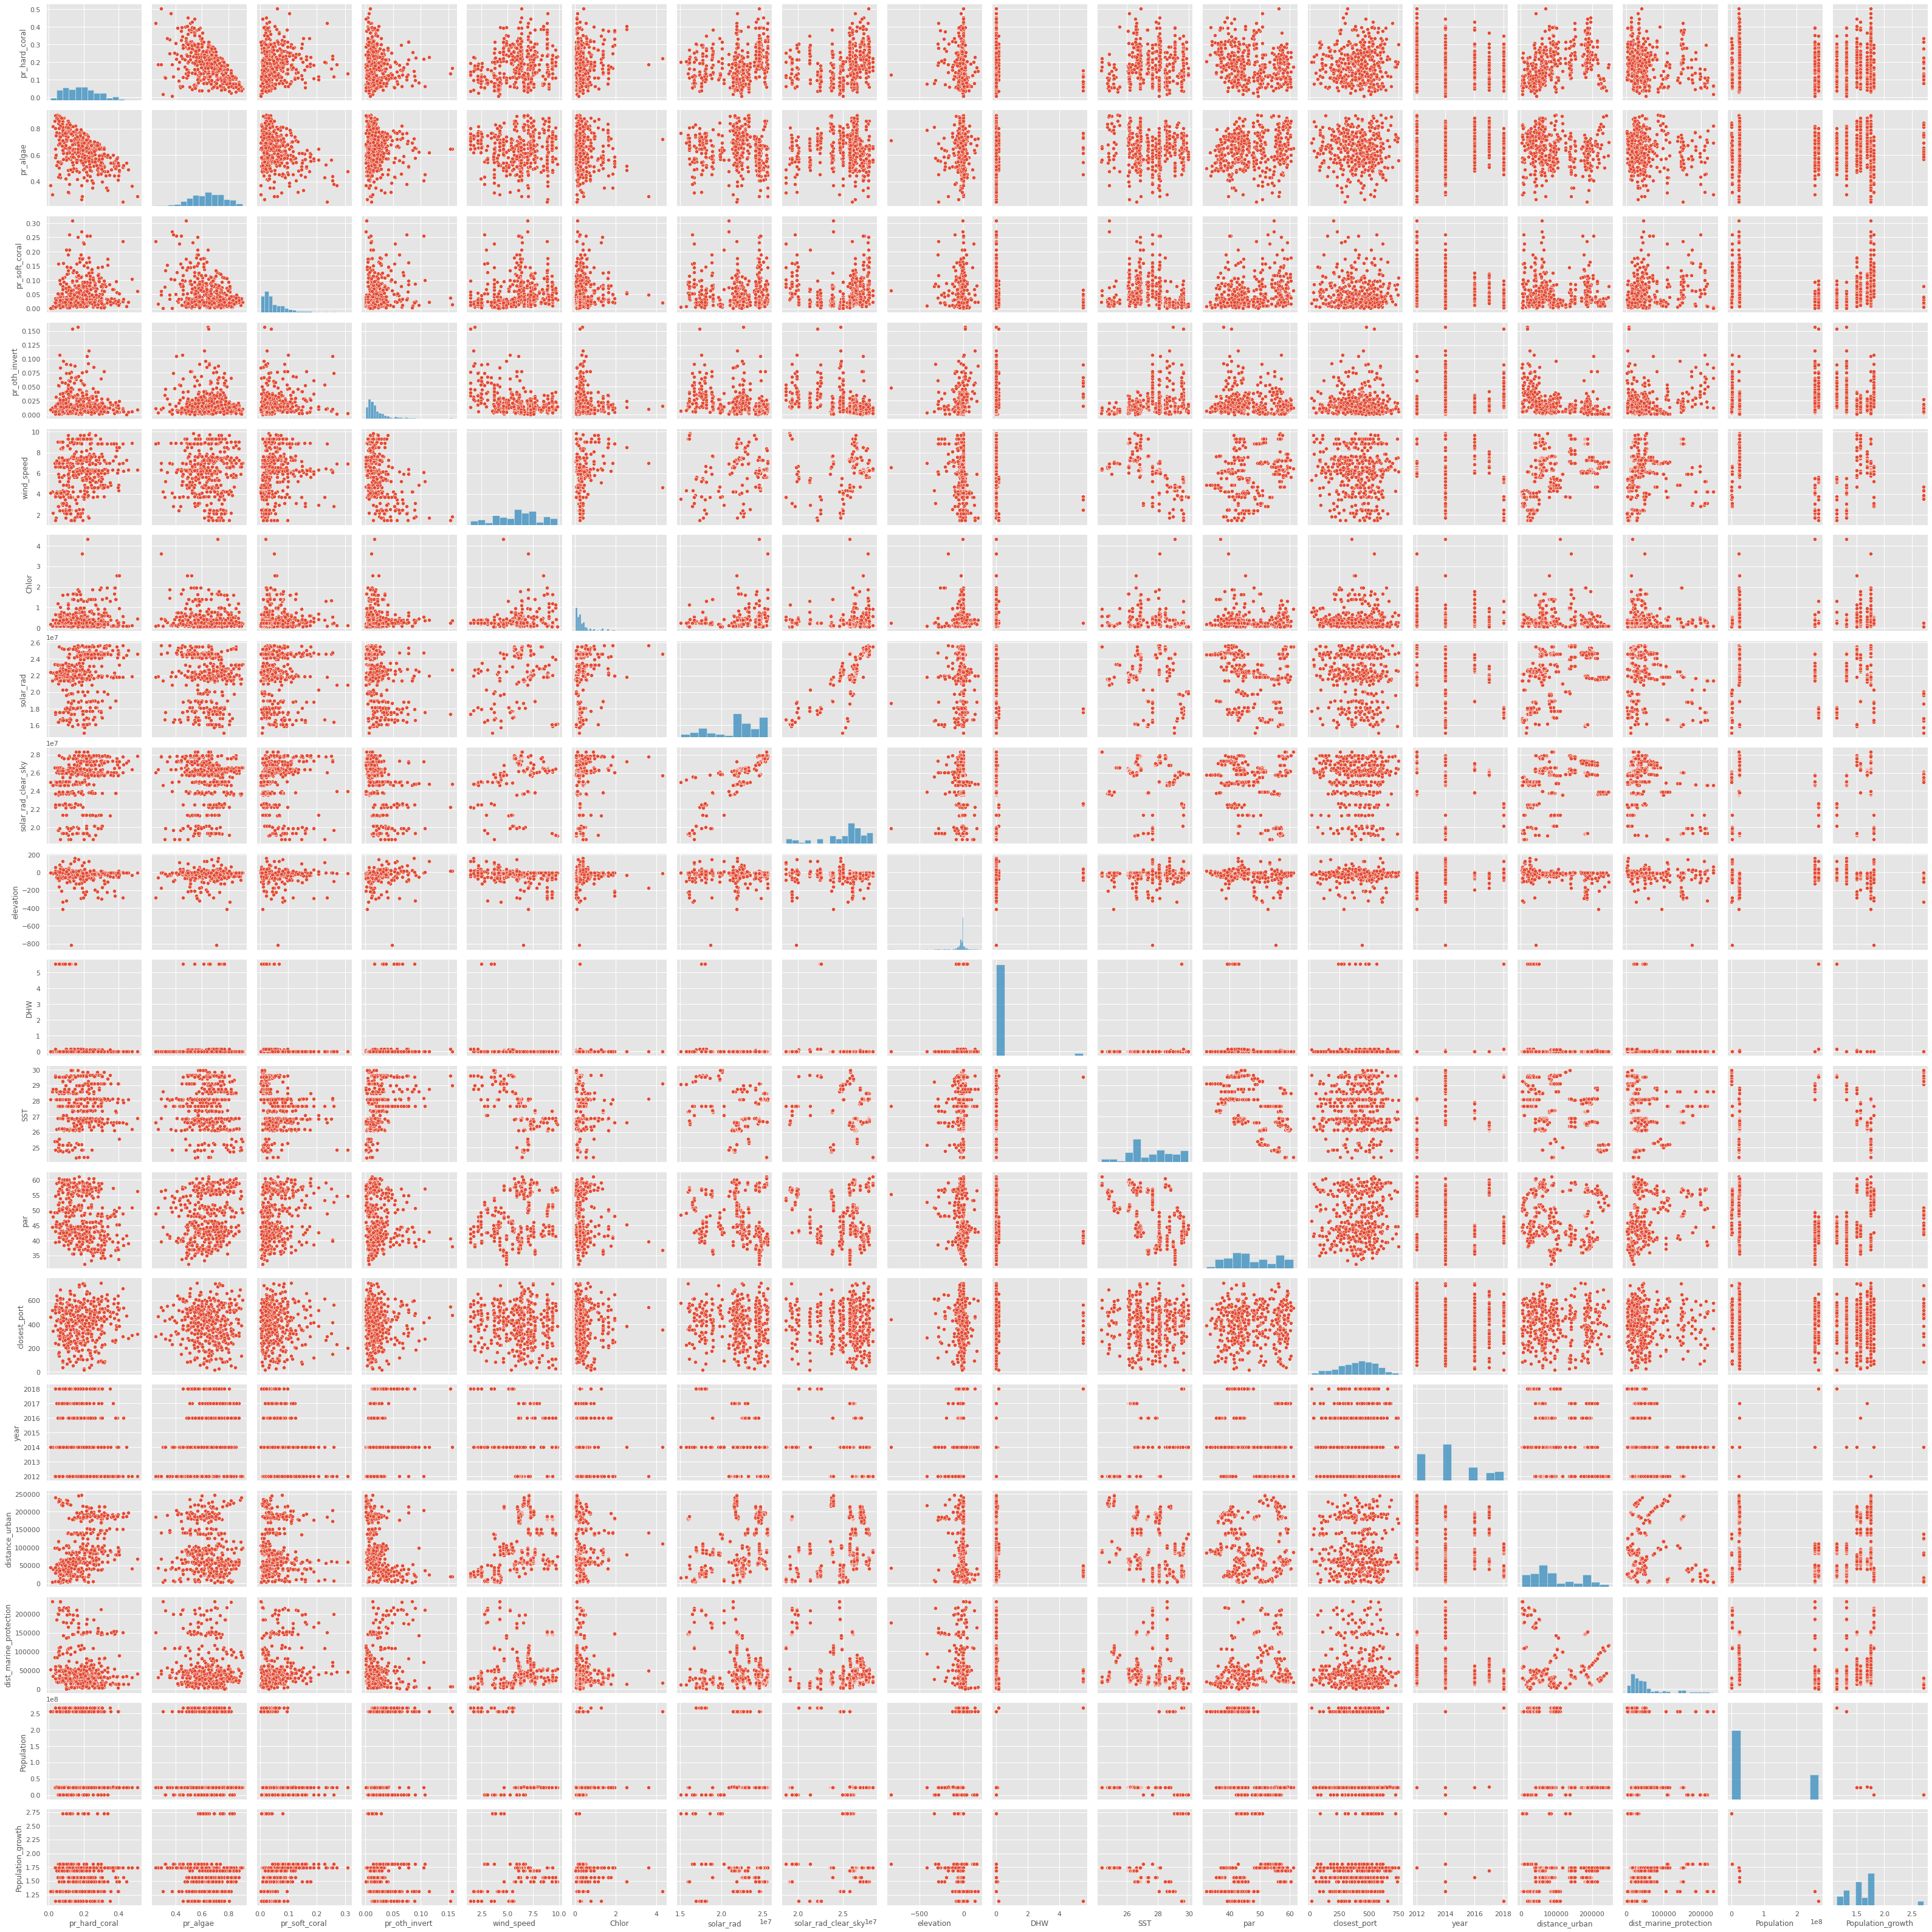

In [460]:
sns.pairplot(df_plot)